# [E-08]News SummaryBot ( 뉴스 요약봇 )
_____

## 목차
### 1. 개요
    1.1 들어가기에 앞서
    1.2 루브릭 평가기준
### 2. 프로젝트: 뉴스기사 요약해보기
    2.1 데이터 준비하기
    2.2 데이터 전처리 - 데이터 정리
    2.3 데이터 전처리 - 훈련데이터 및 테스트데이터 나누기
    2.4 데이터 전처리 - 정수 인코딩
    2.5 모델 설계 및 훈련
    2.6 모델 테스트
    2.7 추출적 요약
### 3. 결론
    3.1 결론
    3.2 참조
    3.3 회고

-----


## 1. 개요
### 1.1 들어가기에 앞서

---

#### 학습 목표
- Extractive/Abstractive summarization 이해하기
- 단어장 크기를 줄이는 다양한 text normalization 적용해보기
- seq2seq의 성능을 Up시키는 Attention Mechanism 적용하기

---

#### 노드 Questions
##### Q1. RNN은 학습 데이터의 길이가 길어질수록 먼 과거의 정보를 현재에 전달하기 어렵다는 문제가 있다. 이 문제를 해결하기 위해 LSTM과 GRU가 등장했고, 이 둘도 부족해서 어텐션(Attention) 메커니즘이 등장했다. 이 문제의 이름은 무엇인가?

- 장기 의존성 문제

#### Q2. 구글에서 텍스트 요약을 위해 시도했던 접근법 중에, 텍스트마이닝 분야의 '역문서빈도(IDF)같은' 지표를 활용해 문서 안에서 중요해 보이는 부분을 추출하고 그걸 요약문에 담는 방식을 썼을 때의 문제점은 무엇이었나?

- 어색하거나 문법적으로 이상한 결과물을 만드는 문제가 있음

#### Q3. 구글은 짧은 문장. 요약문을 생성하는 모델을 딥 러닝을 통해 end-to-end로 설계하도록 했다. 구글이 메일서비스에 적용한 자동 회신(Smart Reply) 기능을 만든 것과 비슷한 딥러닝 기법이기도 한 인코더와 디코더의 구조로 구성된 이 딥 러닝 아키텍처의 이름은 무엇인가?

- seq2seq(sequence-to-sequence)

---

#### 이론 정리

###### 텍스트 요약 
- 긴 문장을 짧게 요약하는 것인데, 핵심적인 것은 정보 손실 발생 최소화되어야 한다는 점이다. 요약은 **추출적 요약, 추상적 요약** 두 가지로 나눔

###### 추출적 요약(Extractive Summarization)
- 단어 그대로 원문에서 문장들을 추출하여 요약하는 방식. 단, 꺼내온 문장들의 연결이 자연스럽지 않을 수 있다. 그렇기에 딥러닝보다는 택스트 랭크(TextRank)와 같은 알고리즘으로 이 방법을 사용

###### 추상적 요약(Abstractive Summarization)
- 원문으로부터 내용이 요약된 새로운 문장을 생성하는 방식. 문장을 분류하는 추출적 요약과는 다르게 자연어 생성의 영역인 셈이다.

###### 텍스트 정규화
- 텍스트 처리에서 줄임표현이 된 같은 표현을 학습 전에 미리 같은 표현이라고 통일시켜주는 방법

---

### 1.2 루브릭 평가기준
평가문항|상세기준
-|-
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

---
## 2. 프로젝트: 뉴스기사 요약해보기
### 2.1 데이터 준비하기

In [13]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- NLTK 패키지에서 불용어 사전 다운로드
- 데이터 전처리를 위한 패키지 불러오기


In [14]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 다운로드 받은 데이터는 총 568,454개의 샘플
- 시간상의 문제로 10만개의 샘플만 사용

In [17]:
data.sample(10)

,headlines,text
62582,Makes no difference: Sonakshi on rumour of fig...,"Sonakshi Sinha, while speaking about rumours o..."
20223,Tata Sons increase stake in Tata Motors to 33.4%,Tata Sons bought shares of Tata Motors for the...
39618,"Kundra not part of Bitcoin scam, only a witnes...",The spokesperson of Shilpa Shetty's husband Ra...
5020,'Mahagathbandhan' an alliance for personal sur...,Terming 'Mahagathbandhan' as a club of rich dy...
2307,CBFC's scissors very small thing for Thackeray...,Amid reports of CBFC raising an objection to t...
15494,Never expected Hirani to become a great filmma...,Nawazuddin Siddiqui has said he never expected...
61768,SC dismisses petition filed against release of...,The Supreme Court has dismissed a petition fil...
57130,World's 1st traffic light blew up a month afte...,The world's first ever traffic lights were ins...
35656,Syria used chemical weapons 50 times during ci...,The US estimates that Syrian forces backed by ...
89051,My kids get upset when I stop to sign autograp...,Actress Juhi Chawla has revealed that her kids...


- 10개의 무작위 샘플 추출

---

### 2.2 데이터 전처리 - 데이터 정리

다음과 같은 데이터 정리

- 빈칸으로 존재하는 null 데이터

- 의미가 같은 중복항목 데이터

- 학습할 때 방해가 되는 데이터


In [19]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- 중복을 배제한 샘플 수 확인

In [21]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- drop_duplicates()를 사용하여 중복 샘플 제거

In [22]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- .isnull().sum()를 사용하여 데이터프레임에 Null 값이 있는지 확인
- null 데이터가 없음

In [23]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- null 데이터가 없으므로, 전체 샘플수는 그대로 유지

In [24]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


- 학습 전에 미리 같은 표현들을 통일시켜주는 정규화 작업
- 정규화된 사전의 수는 120개

In [25]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- NLTK에서 제공된 불용어는 179개

In [27]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- preprocess_sentence 함수로 데이터를 전처리
- sentence.lower()로 텍스트 소문자화
- BeautifulSoup()로 html 태그 제거
- re.sub로 괄호로 닫힌 문자열 제거, 쌍따옴표 제거, 소유격 제거, 영어 외 공백으로 변환, m이 3개 이상이면 2개로 변환
- 약어 정규화 
- text (불용어 제거), headlines (불용어 미제거)

In [29]:
clean_text = []
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

- text는 불용어를 제거하고, headlines는 불용어를 제거하지 않으므로 따로 호출하여 전처리

In [32]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- 불용어를 제거하지 않는다는 의미로 두 번째 인자로 False를 추가

In [34]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
dtype: int64

- 텍스트 정제 과정 거친 후, 빈 샘플이 생겼는 지 확인
- null 값은 생기지 않음

---

### 2.3 데이터 전처리 - 훈련데이터 및 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


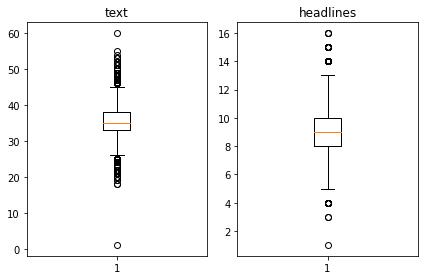

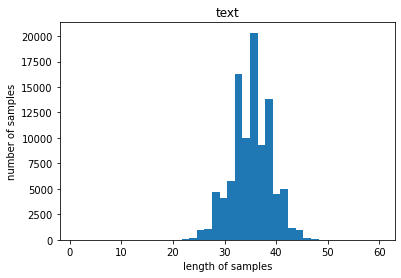

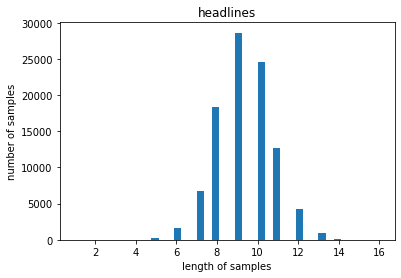

In [38]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text와 headlines의 최소, 최대, 평균 길이 측정
- 길이 분포 그래프로 시각화
- 길이에 따른 샘플의 차이를 보임


In [50]:
text_max_len = 46
headlines_max_len = 13

- 그래프를 보고 길이를 각각 46과 14로 정하여, 샘플들을 자르지 않고 최대한 포함할 수 있도록 함

In [51]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [52]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 46 이하인 샘플의 비율: 0.9990537818204017
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.998168609974971


- 46과 13으로 패딩하여 나머지 샘플들을 자르면, 99% 이상의 데이터를 포함

In [53]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98013


-기존의 전체 샘플 수 98306개에서 정해진 길이보다 긴 데이터를 제외하고 98013개만 남음

In [55]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


- 시작 토큰 sos와 종료 토큰 eos를 시퀀스의 앞,뒤로 추가
- 두 개의 문장 모두 headlines 열로 만들기

In [56]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

- 인코더의 입력, 디코더의 입력과 레이블을 각각 넘파이 타입으로 저장

In [58]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[30662  4052 24390 ... 15593 57567 54565]


- 인코더 입력과 크기,형태가 같은 순서가 섞인 정수 시퀀스 만들기

In [59]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

- 위 정수 시퀀스를 이용해 재차 데이터의 샘플 순서를 정하여 샘플을 잘 섞어줌

In [61]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19602


- 섞인 데이터의 비율을 8대2로 훈련 데이터 및 테스트 데이터 분리

In [62]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :',len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78411
훈련 레이블의 개수 : 78411
테스트 데이터의 개수 : 19602
테스트 레이블의 개수 : 19602


- 훈련 데이터와 테스트 데이터가 8대2 비율로 잘 분리됨

---

### 2.4 데이터 전처리 - 정수 인코딩

In [63]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

- Keras의 토크나이저를 사용하여, 입력된 훈련 데이터로부터 단어집합 생성
- 원문에 해당하는 'encoder_input_train'에 대해 단어 집합 생성

In [64]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69511
등장 빈도가 6번 이하인 희귀 단어의 수: 47386
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22125
단어 집합에서 희귀 단어의 비율: 68.1705053876365
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.497668899365673


- 단어 집합에서 등장 빈도가 7회 미만(6회 이하)인 단어의 수 확인
- 빈도 수가 낮은 단어들은 훈련데이터에서 제외하기 위해, 단어 집합에서 희귀 단어의 비율과 전체 등장 빈도에서 희귀 단어 등장 빈도 비율 확인

In [65]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- 위에서 희귀 단어를 제외시킨 단어집합 크기를 22,125로 계산했기에, 단어 집합의 크기를 22,000으로 제한

In [66]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3656, 5476, 1435, 11229, 3480, 530, 519, 1067, 1732, 57, 988, 1367, 3656, 7432, 55, 6302, 2253, 688, 6694, 574, 2119, 519, 1091, 16001, 6302, 2253, 3656, 119, 165, 13, 3250, 1, 609], [1865, 50, 10941, 73, 206, 8017, 1, 228, 676, 182, 1133, 4138, 108, 30, 2934, 4632, 11230, 228, 182, 419, 317, 3, 11, 50, 24, 597, 6098, 665, 459, 9823], [764, 2716, 1929, 3171, 3303, 267, 1316, 56, 53, 4877, 267, 7550, 764, 8658, 429, 41, 404, 1247, 9483, 101, 267, 7550, 7023, 1733, 451, 764, 24, 55, 1232, 6695]]


- 테긋트 시퀀스를 정수 시퀀스로 변환

In [67]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

디코더 입력도 인코더 입력과 마찬 가지로 케라스 토크나이저를 사용하여 훈련 데이터로부터 단어집합 생성

In [68]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30029
등장 빈도가 5번 이하인 희귀 단어의 수: 19589
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10440
단어 집합에서 희귀 단어의 비율: 65.23360751273769
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6344905517303765


- 단어 집합에서 등장 빈도가 6회 미만(5회 이하)인 단어의 수 확인
- 빈도 수가 낮은 단어들은 훈련데이터에서 제외하기 위해, 단어 집합에서 희귀 단어의 비율과 전체 등장 빈도에서 희귀 단어 등장 빈도 비율 확인

In [69]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2130, 8806, 1886, 498, 12, 924, 18, 4994, 3, 18, 669], [1, 47, 19, 104, 3407, 5645, 164, 130, 326, 64, 6, 194, 99], [1, 20, 4819, 3589, 633, 111, 1047, 212, 1150], [1, 7667, 550, 301, 6469, 3, 1711, 546, 301, 2016, 4022], [1, 405, 1887, 11, 1542, 182, 1067, 5, 34, 54]]
target
decoder  [[2130, 8806, 1886, 498, 12, 924, 18, 4994, 3, 18, 669, 2], [47, 19, 104, 3407, 5645, 164, 130, 326, 64, 6, 194, 99, 2], [20, 4819, 3589, 633, 111, 1047, 212, 1150, 2], [7667, 550, 301, 6469, 3, 1711, 546, 301, 2016, 4022, 2], [405, 1887, 11, 1542, 182, 1067, 5, 34, 54, 2]]


- 아까와 마찬가지로 10,000 단어를 집합의 크기로 제한

In [70]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78411
훈련 레이블의 개수 : 78411
테스트 데이터의 개수 : 19602
테스트 레이블의 개수 : 19602


- 삭제할 데이터의 개수가 없음

In [71]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

- 시퀀스 변환이 완료된 상황에서, 서로 다른 길이의 샘플들을 병렬 처리하기 위해 패딩으로 길이를 맞춰줌

- 패딩은 최대 길이로 작업

---

### 2.5 모델 설계 및 훈련

In [72]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- 임베딩 벡터의 차원: 128
- hidden state의 크기 : 256
- hidden state는 LSTM에서 얼만큼의 수용력을 가질지 결정하는 파라미터
- 인코더의 LSTM은 총 3개의 층으로 구성하여 모델의 복잡도를 향상
- 3갸의 층을 지나 인코더의 출력 벡터가 디코더로 입력
- 출력에서 오류가 잡힌 것은, recurrent dropout을 사용했기 때문

In [73]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 디코더를 설계하고, 임베딩 층과 LSTM 설계
- LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어주어야 함

In [74]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 디코더의 출력층 설계

In [75]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 46, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 46, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- seq2seq 기본 모델과 달리, 어텐션 메커니즘을 이용
- 인코더의 hidden state, 디코더의 hidden state 들은 어텐션 함수의 입력으로 사용
- 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 214s 645ms/step - loss: 4.8802 - val_loss: 4.4812
Epoch 2/50
307/307 [==============================] - 196s 637ms/step - loss: 4.3378 - val_loss: 4.1390
Epoch 3/50
307/307 [==============================] - 196s 638ms/step - loss: 4.0489 - val_loss: 3.9333
Epoch 4/50
307/307 [==============================] - 195s 636ms/step - loss: 3.8268 - val_loss: 3.7576
Epoch 5/50
307/307 [==============================] - 195s 637ms/step - loss: 3.6546 - val_loss: 3.6312
Epoch 6/50
307/307 [==============================] - 196s 639ms/step - loss: 3.5112 - val_loss: 3.5431
Epoch 7/50
307/307 [==============================] - 195s 637ms/step - loss: 3.3895 - val_loss: 3.4692
Epoch 8/50
307/307 [==============================] - 195s 636ms/step - loss: 3.2820 - val_loss: 3.4061
Epoch 9/50
307/307 [==============================] - 195s 636ms/step - loss: 3.1878 - val_loss: 3.3498
Epoch 10/50
307/307 [==============================] - 195s 635m

- 설계 모델 훈련
- callbacks 함수로 최적점에 EarlyStopping이 작동
- 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 조기종료

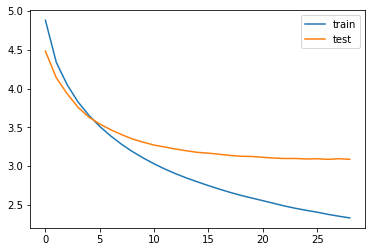

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 훈련 데이터의 손실 및 검증 데이터의 손실 과정 그래프로 시각화

---

### 2.6 모델 테스트

In [78]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

- 정수 인덱스 행렬로 존재하던텍스트 데이터를 실제 데이터로 복원하기 위해 3개의 사전 준비

In [80]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- 인코더 모델과 디코더 모델을 분리하여 설계

In [81]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

- 어텐션 메커니즘을 사용하는 출력층 설계

In [82]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

- 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 만들기

In [83]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 만들기

In [84]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sunny deol tweeted picture son karan mark first day shoot debut film pal pal dil ke paas father launched launching son said sunny directing co producing film title reportedly inspired song dharmendra film black mail 
실제 요약 : sunny shares pic from son st day of shoot for debut film 
예측 요약 :  sunny leone shares pic of her st birthday


원문 : officials three uttar pradesh medical colleges among meeting criteria functioning caught camera selling mbbs seats admissions offered illegal ban lifted institutions demanding lakh book seat lakh total mbbs package 
실제 요약 : up medical colleges officials caught on camera selling seats 
예측 요약 :  up to get married to buy meat in up


원문 : australian windies women cricket team captains got argument toss world cup match monday windies captain taylor told australian counterpart meg referee would bat first changed decision referee intervened declared taylor would stick original decision 
실제 요약 : captains get into argument during toss at women world cup 

- 데스트 데이터 10개의 샘플에 대해 실제 요약과 예측 요약을 비교

---

### 2.7 추출적 요약

In [105]:
import requests
from summa.summarizer import summarize

- Summa의 summarizer 모듈 불러오기

In [106]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 매트릭스 시놉시스 다운로드

In [112]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.7))

In [113]:
for i in range(10):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출 요약 : The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit 

- ratio를 낮게 하면 추출 요약을 뽑아내지 못하는 원문도 있어, ratio = 0.7 로 두었다
- 데스트 데이터 10개의 샘플에 대해 실제 요약과 추출 요약을 비교

---
## 3. 결론
### 3.1 결론

### 예측 요약과 추출 요약

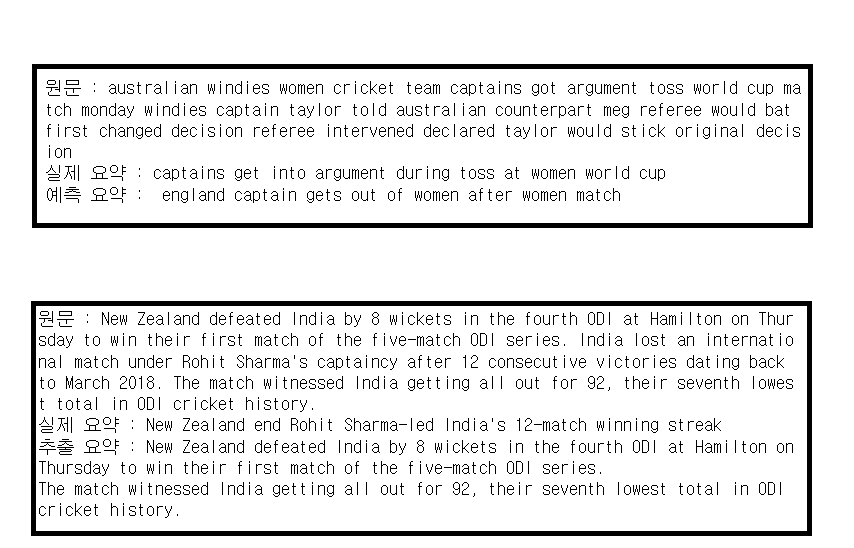

위 사진은  Abstractive 요약과 Extractive 요약 샘플에 대해 한 가지씩 임의로 예시를 가져온 것이다.

예측 요약은 원문과는 다르게 비교적 새로운 문장을 뽑아내어 결과를 도출했고, 추출 요약은 대부분 원문에서 뽑아 온 문장들로 구성하여 결과를 도출해냈다.

---
### 3.2 참조
추출 요약: https://wikidocs.net/91051

---
### 3.3 회고

- 이번 회고는 앞으로 나의 노력이 많이 요구될 것 같아, 자기 반성적 위주로 작성했다..!

모델 학습

> 평소 퍼실님들 께서 점점 가면 갈 수록 모델을 학습시키는 시간이 길어질 노드가 많아질 것이라고 했었다. 이번 노드를 하기 전까지는 모델 학습 시간에 크게 투자해본적이 없었기에 위압감을 느끼지 못했었다. 이번 노드 같은 경우 다른 사람들에 비해 한 에포크당 소요시간이 다소 더 걸렸다. 물론 callbacks 함수를 사용하여 조기종료가 되었으나, 중간에 '정말 50 에포크까지 돌리면 어떡하지?' 라는 생각이 들었다. 만약 프로젝트 제출 당일 날 모델 학습을 한다고 했을 때 차질이 생긴다면 처참할 것이다. 그렇기에 얼른 미숙한 부분들을 채우고, 시간 관리를 철저히하여 노드가 밀리는 일이 생기지 않게 해야겠다.

영포자는 그만..

> 이번 프로젝트 노드에서 원문과 요약이 영어로 되어있기에 영포자인 나로서는 문장을 잘 생성했는지 혹은 문장을 잘 분류했는지 확인하기 버거웠다. 물론 해석하는 방법에는 문제가 없겠지만, 문법이든 단어든 영어 공부를 너무 오랜 기간 안 했다는 생각이 크게 들었다. 객관적으로 보았을 때 '겨우 이 정도를..?'이라는 생각이 들어 영어 학습에 대한 요구가 더 느껴졌다. 앞서 말한 것뿐 아니라 추후에는 더 난해한 영어 문장을 만나거나, 실무에서는 더한 영어능력을 요구하기 때문에 영어학습의 필요를 계속 되새기도록 해야겠다.

NLP와 CV 무엇을..?

> 슬슬 어느 분야를 선택해야할지 결정내려야 하는 순간이 다가오고 있다. 인공지능에 대해 배운지 이제 한 달이 지났는데, 노드의 난이도로만 판단했을 때는 컴퓨터 비전 관련 노드가 자연어 처리 노드에 비해 비교적 수월했다. 결과를 시각적으로 확인할 수 있기 때문에 수월했던 것 같다. 반면 자연어 처리의 경우 노드를 수행하고 나면, 의도대로 결과를 도출해냈는지 혹은 과정을 이해했는지 판단을 내리기가 어렵다. 그래도 아직 선택을 고민하는 것은 분야의 극히 일부분만 다루어보았기 때문이다. 분명 자연어 처리에 대해서도 흥미를 끌어올릴 수 있는 배움 과정이 있다면 NLP에 관심을 더 가져보고 싶다. 얼마남지 않은 기간동안 내가 희망하는 분야를 찾기 위해 더 깊게 관찰하고 고민할 필요를 크게 느낀다.